In [50]:
!pip install -q utils
# !pip install -q mxnet
import tensorflow as tf
print(tf.__version__)

2.2.0-rc1


In [0]:
import pandas as pd
import numpy as np
from utils import *
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings("ignore")

def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')
    

In [53]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/Karunanidhimishra/dataset/master/pca_final.csv \
    -O /tmp/pca_final.csv

--2020-03-30 07:15:16--  https://raw.githubusercontent.com/Karunanidhimishra/dataset/master/pca_final.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1419709 (1.4M) [text/plain]
Saving to: ‘/tmp/pca_final.csv’

/tmp/pca_final.csv  100%[===================>]   1.35M  --.-KB/s    in 0.08s   

2020-03-30 07:15:16 (17.7 MB/s) - ‘/tmp/pca_final.csv’ saved [1419709/1419709]



                    0         1         2  ...         12         13     Close
Date                                       ...                                
1999-05-04 -12.917990  1.375321  6.387418  ...  13.631289  39.130115 -1.385794
1999-05-05 -10.852073  0.195517  2.114841  ...  -1.156029  -6.171409 -1.409145
1999-05-06 -10.213734 -0.017728  3.080872  ...   1.129027  -6.774328 -1.431384
1999-05-07  -6.560070 -3.698563  7.470918  ...   0.938084  -6.697004 -1.315676
1999-05-10  -8.006509 -2.123368  3.959522  ...   0.158472  -5.693717 -1.379872

[5 rows x 15 columns]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f73c4ed0160>,
      dtype=object)

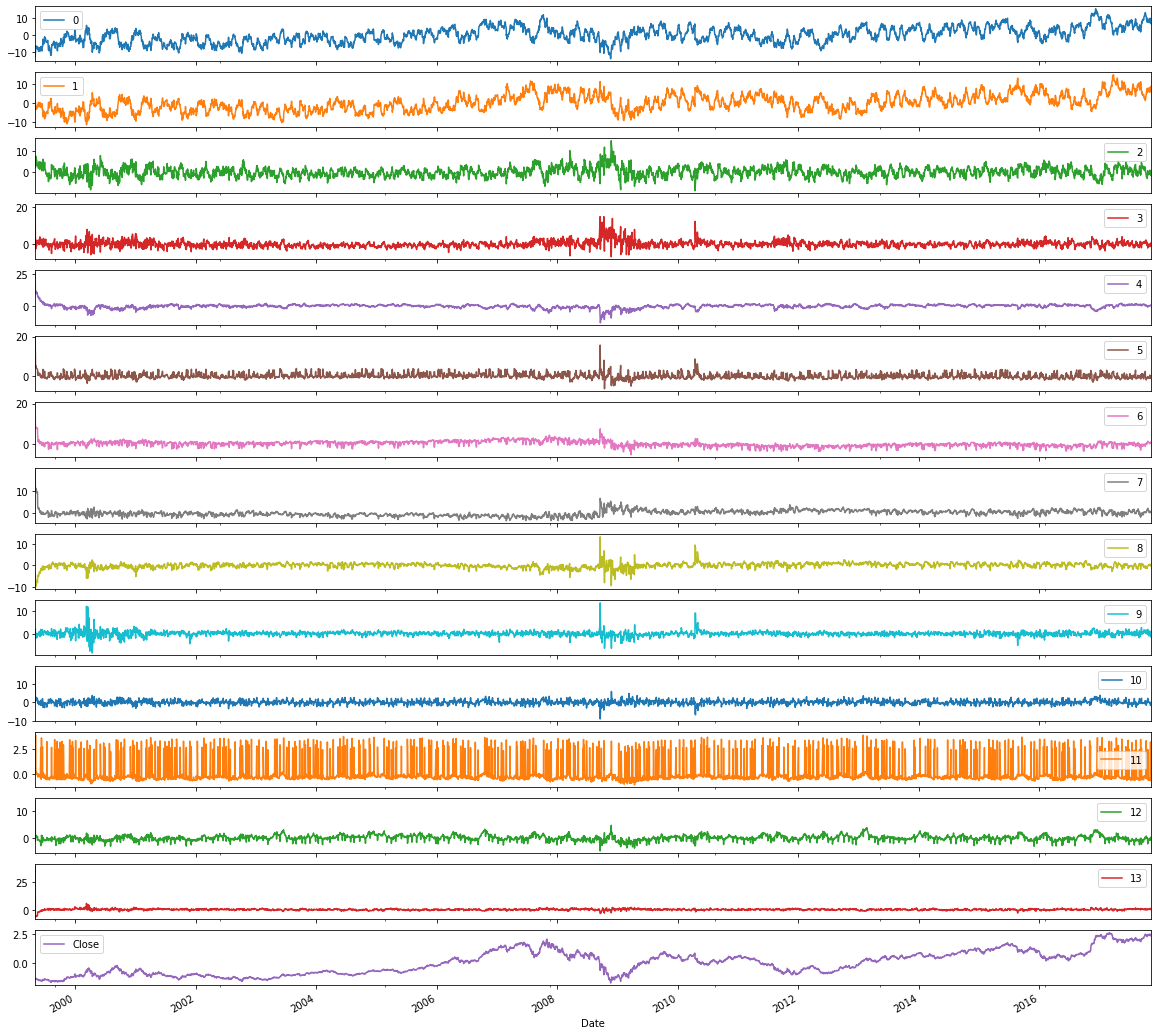

In [65]:
pca_final=pd.read_csv('/tmp/pca_final.csv', header=0, parse_dates=[0], date_parser=parser).set_index('Date')
features=pca_final.copy()
print(features.head())
features.plot(subplots=True, figsize=(20, 20))

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
series = features.values
time =features.index.values
split_time = int(series.shape[0] * 0.80)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[:-1,-1]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [59]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs['mae']< 1):
      print("\nReached less than 1 mae so cancelling training!")
      self.model.stop_training = True
mae_stop = myCallback()
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None,x_train.shape[1]]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule,mae_stop])

Epoch 1/100
15/15 [==============================] - 5s 308ms/step - loss: 20.0032 - mae: 20.5101 - lr: 1.0000e-08
Epoch 2/100
15/15 [==============================] - 5s 302ms/step - loss: 19.8662 - mae: 20.3925 - lr: 1.1220e-08
Epoch 3/100
15/15 [==============================] - 5s 307ms/step - loss: 19.7931 - mae: 20.2346 - lr: 1.2589e-08
Epoch 4/100
15/15 [==============================] - 5s 306ms/step - loss: 19.5101 - mae: 20.0551 - lr: 1.4125e-08
Epoch 5/100
15/15 [==============================] - 5s 305ms/step - loss: 19.3320 - mae: 19.8566 - lr: 1.5849e-08
Epoch 6/100
15/15 [==============================] - 5s 305ms/step - loss: 19.1368 - mae: 19.6403 - lr: 1.7783e-08
Epoch 7/100
15/15 [==============================] - 5s 307ms/step - loss: 18.8649 - mae: 19.4041 - lr: 1.9953e-08
Epoch 8/100
15/15 [==============================] - 5s 306ms/step - loss: 18.6700 - mae: 19.1466 - lr: 2.2387e-08
Epoch 9/100
15/15 [==============================] - 5s 306ms/step - loss: 18.33

(1e-08, 0.0001, 0.0, 60.0)

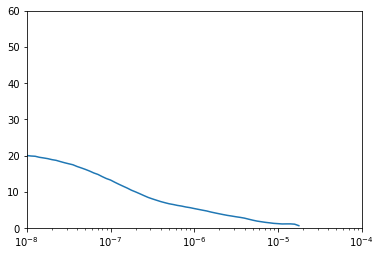

In [60]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [61]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs['mae']< 1):
      print("\nReached less than 1 mae so cancelling training!")
      self.model.stop_training = True
mae_stop = myCallback()
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None,x_train.shape[1]]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule,mae_stop])

Epoch 1/100
15/15 [==============================] - 4s 299ms/step - loss: 20.0032 - mae: 20.5101 - lr: 1.0000e-08
Epoch 2/100
15/15 [==============================] - 4s 298ms/step - loss: 19.8662 - mae: 20.3925 - lr: 1.1220e-08
Epoch 3/100
15/15 [==============================] - 4s 297ms/step - loss: 19.7931 - mae: 20.2346 - lr: 1.2589e-08
Epoch 4/100
15/15 [==============================] - 5s 300ms/step - loss: 19.5101 - mae: 20.0551 - lr: 1.4125e-08
Epoch 5/100
15/15 [==============================] - 5s 303ms/step - loss: 19.3320 - mae: 19.8566 - lr: 1.5849e-08
Epoch 6/100
15/15 [==============================] - 5s 306ms/step - loss: 19.1368 - mae: 19.6403 - lr: 1.7783e-08
Epoch 7/100
15/15 [==============================] - 5s 308ms/step - loss: 18.8649 - mae: 19.4041 - lr: 1.9953e-08
Epoch 8/100
15/15 [==============================] - 5s 305ms/step - loss: 18.6700 - mae: 19.1466 - lr: 2.2387e-08
Epoch 9/100
15/15 [==============================] - 5s 308ms/step - loss: 18.33

In [0]:
rnn_forecast = model_forecast(model, series[...], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

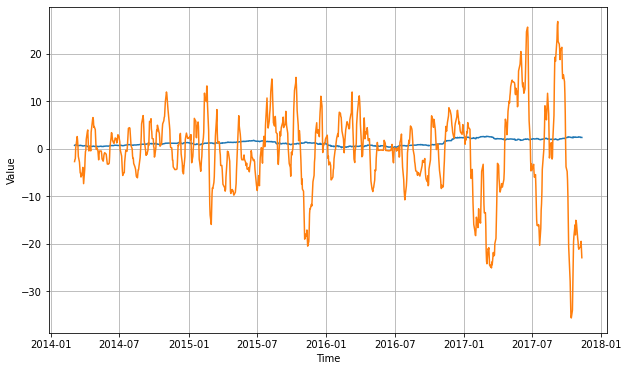

In [64]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid[:,-1])
plot_series(time_valid, rnn_forecast)